# Sembradora 3000

It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [1]:

# Model design
import agentpy as ap
import random
import numpy as np
from collections import namedtuple, deque
from queue import PriorityQueue
from itertools import count
import math

# Visualization
import imageio
import imageio.v2 as imageio
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import matplotlib.image as mpimg
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import HTML
from tempfile import TemporaryDirectory

# Guardar
import pickle

# Sistema
import os

# Machine learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

## Grid

In [2]:
"""
0 is empty
1 is tractor
2 is obstacle
3 is target
4 is seeds
"""

def is_connected(grid, free_positions):
    """Check if all free cells are connected using BFS."""
    n = grid.shape[0]
    visited = set()
    queue = deque([free_positions.pop()])
    visited.add(queue[0])

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    connected_count = 0
    free_count = len(free_positions)

    while queue:
        x, y = queue.popleft()
        for dx, dy in directions:
            new_x, new_y = x + dx, y + dy
            if (0 <= new_x < n and 0 <= new_y < n and 
                (new_x, new_y) in free_positions and (new_x, new_y) not in visited):
                queue.append((new_x, new_y))
                visited.add((new_x, new_y))
                connected_count += 1
                
    return connected_count == free_count

def is_adjacent(pos1, pos2):
    return abs(pos1[0] - pos2[0]) <= 1 and abs(pos1[1] - pos2[1]) <= 1

def generate_grid(model, n, obstacles_count, crops_count):
    """Generate a grid with obstacles, ensuring free cells are connected."""
    while True:
        grid = ap.Grid(model, (n, n), track_empty=True)
        grid.add_field("occupied", 0)

        obstacle_positions = set()
        while len(obstacle_positions) < obstacles_count:
            pos = (random.randint(0, n-1), random.randint(0, n-1))
            if pos not in obstacle_positions:
                # Check if pos is adjacent to any seed position
                is_valid = True
                for seed_pos in model.p.seedsPositions:
                    if is_adjacent(pos, seed_pos):
                        is_valid = False
                        break
                if is_valid:
                    obstacle_positions.add(pos)

        for pos in obstacle_positions:
            grid["occupied"][pos] = 1

        free_positions = {(x, y) for x in range(n) for y in range(n) if grid["occupied"][x, y] == 0}
        
        if is_connected(grid, free_positions):
            break

    for pos in obstacle_positions:
        grid["occupied"][pos] = 1
        model.np_grid[pos] = 2
        
        crops_positions = set()
        while len(crops_positions) < crops_count:
            pos = (random.randint(0, n-1), random.randint(0, n-1))
            if pos not in obstacle_positions and pos not in crops_positions:
                crops_positions.add(pos)
                model.np_grid[pos] = 3

    agentlist = ap.AgentList(model, len(obstacle_positions), agent_type=2)
    grid.add_agents(agentlist, obstacle_positions)
    
    model.grid = grid
    
    return obstacle_positions, crops_positions

## Agente

In [3]:

class CollectingTractor(ap.Agent):
    def setup(self):
        """Initialize agent parameters."""
        self.initialized = False
        self.reset()

    def reset(self):
        """Reset agent attributes."""
        if not self.initialized:
            self._initialize_agent()
        else:
            self._restore_agent()

    def _initialize_agent(self):
        """Initialize the agent's initial state."""
        self.planted = 0
        self.destroyed = False
        self.seeds = 0
        self.type = 1
        self.past_pos = (0, 0)
        self.pos = (0, 0)
        self.new_pos = (0, 0)
        self.visited_positions = set()
        self.cell_state = 0 
        self.last_action = None 
        self.last_planting_pos = None
        self.steps_without_plant = 0
        self.last_movAction = None
        
        # Initialize Q-learning parameters
        self.q_table = np.zeros((self.p.grid_size, self.p.grid_size, self.p.capacity + 1, 7))
        self.learning_rate = self.p.learning_rate
        self.discount_factor = self.p.discount_factor
        self.epsilon = self.p.epsilon

        self.initialized = True  # Mark as initialized

    def _restore_agent(self):
        """Restore the agent's state to its initial conditions."""
        self.planted = 0
        self.targetIndex = 1
        self.destroyed = False
        self.seeds = 0
        self.type = 1
        self.past_pos = (0, 0)
        self.pos = (0, 0)
        self.new_pos = (0, 0)
        self.visited_positions = set()
        self.cell_state = 0
        self.last_action = None
        self.last_planting_pos = None
        self.steps_without_plant = 0
        self.last_movAction = None

        # Initialize Q-learning parameters
        self.q_table = np.zeros((self.p.grid_size, self.p.grid_size, self.p.capacity + 1, 7))
        self.learning_rate = self.p.learning_rate
        self.discount_factor = self.p.discount_factor
        self.epsilon = self.p.epsilon
        
    def setCellState(self, pos):
        if self.model.np_grid[pos] == 3:
            self.cell_state = 0
        elif self.model.np_grid[pos] == 4:
            self.cell_state = 1
        else:
            self.cell_state = 2
    
    def exitGrid(self):
        self.pos = (None, None)
        
    def setNewPositionVerify(self, pos):
        self.new_pos = pos
        
    def move(self, agentes, dx=0, dy=0):
        """Move the tractor by (dx, dy)."""
        x, y = self.pos
        new_pos = (x + dx, y + dy)

        # Asegúrate de que la nueva posición está dentro de los límites de la cuadrícula
        if 0 <= new_pos[0] < self.p.grid_size and 0 <= new_pos[1] < self.p.grid_size:
            # Verifica si la nueva posición no es un obstáculo
            if self.model.np_grid[new_pos] != 2 and new_pos != self.p.seedsPositions[0]:
                # Verifica si algún otro agente ya tiene la nueva posición como su siguiente posición
                self.setNewPositionVerify(new_pos)
                for agente in agentes:
                    if agente is not self:
                        if agente.new_pos == new_pos or agente.pos == new_pos:
                            return self.pos, False  # No se puede mover porque la posición está ocupada por otro agente
                # Si no hay obstáculos ni agentes en la nueva posición, se mueve
                self.past_pos = self.pos
                self.pos = new_pos
                self.setCellState(self.pos)
                return self.pos, True
        return self.pos, False  # No se puede mover porque está fuera de los límites o hay un obstáculo

    def move_up(self, agents):
        self.last_movAction = 0
        return self.move(agents, dy=1)

    def move_down(self, agents):
        self.last_movAction = 1
        return self.move(agents, dy=-1)

    def move_left(self, agents):
        self.last_movAction = 2
        return self.move(agents, dx=-1)

    def move_right(self, agents):
        self.last_movAction = 3
        return self.move(agents, dx=1)
    
    def exit(self, agents):
        x, y = self.pos

        # Verifica si el agente ya está en el borde del grid
        if (x == 0 or x == self.p.grid_size - 1 or y == 0 or y == self.p.grid_size - 1) and 3 not in self.model.np_grid:
            self.destroyed = True
            return self.pos, True  
        else:
            return self.pos, False

    def drop(self, agents):
        """Drop seeds at the current target position."""
        if self.seeds > 0 and self.pos and self.model.np_grid[self.pos] == 3:
            self.seeds -= 1
            # Remove target from grid
            self.model.np_grid[self.pos] = 0
            self.planted += 1
            self.last_planting_pos = self.pos
            return self.pos, True
        else:
            return self.pos, False

    def collect(self, agents):
        """Collect seeds if available at the surrounding positions, including diagonals."""
        # Verificar si el agente está en alguna de las celdas adyacentes
        if self.pos in self.model.neighbors:
            if self.seeds == 0:
                self.seeds = self.capacity
                return self.pos, 1
            elif self.seeds > 0 and self.seeds < self.capacity:
                self.seeds = self.capacity
                return self.pos, 2

        # Si el agente no está en ninguna celda adyacente a seedsPositions
        return self.pos, 3 

    def get_reward(self, action, accionado):
        """Calculate the reward based on the action and outcome."""
        reward = -5  # Base penalty for movement to encourage efficiency

        if action in [0, 1, 2, 3]:  # Movement actions
            if accionado:
                reward += -5  # Reduced penalty for valid movement
            else:
                reward += -100  # Strong penalty for hitting an obstacle or invalid move

        elif action == 4:  # Drop seeds
            if accionado:
                reward += 50  # High reward for planting seeds
            else:
                reward += -100  # General penalty for unsuccessful action
            # Reward for planting near the last planting location
            if self.last_planting_pos is not None:
                last_x, last_y = self.last_planting_pos
                current_x, current_y = self.pos
                if abs(last_x - current_x) <= 1 and abs(last_y - current_y) <= 1:
                    reward += 2  # Smaller reward for planting close to last planting

        elif action == 5:  # Collect seeds
            if accionado == 1:  # If no seeds
                reward += 50  # Reward for collecting seeds
            elif accionado == 2:  # If has seeds but not full
                reward += 10  # Reward for collecting seeds when not full
            else:  # If not adjacent to seedsPositions
                reward += -100  # Penalty for missing seeds

        elif action == 6:  # Exit
            if accionado:
                reward += 100
            else:
                reward += -100 

        # Penalize for not planting seeds in a valid position
        if action != 4 and self.model.np_grid[self.pos] == 3 and self.seeds > 0:
            reward += -5

        # Penalize for repeating the same action
        if action in [4, 5] and self.last_action in [4, 5]:
            if action == self.last_action:
                reward -= 5
            else:
                reward += 0

        # Reward for moving and collecting
        if self.last_action in [0, 1, 2, 3] and accionado:
            if action == 5 or action == 4:
                reward += 1
                
        # Reward for moving in the same direction
        if action in [0, 1, 2, 3] and self.last_movAction == action:
            reward += 5
            

        
        return reward

        
    def q_learning_update(self, state, action, reward, next_state):
        pos_x, pos_y, seeds = state
        next_pos_x, next_pos_y, next_seeds = next_state
        
        # Q-value actual considerando las celdas adyacentes
        current_q = self.q_table[pos_x, pos_y, seeds, action]
        # Max Q-value del siguiente estado
        max_next_q = np.max(self.q_table[next_pos_x, next_pos_y, next_seeds])

        # Actualizar el valor Q
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        self.q_table[pos_x, pos_y, seeds, action] = new_q
        
        if self.destroyed:
            self.exitGrid()

    def acciones(self, action, agents):
        """Map action to the corresponding method."""
        action_map = {
            0: self.move_up,
            1: self.move_down,
            2: self.move_left,
            3: self.move_right,
            4: self.drop,
            5: self.collect,
            6: self.exit
        }
        if action != 4:
            self.steps_without_plant += 1
        accion = action_map[action]
        return accion(agents)

    def step(self, agents):
        """Execute a step in the agent's behavior."""
        self.planted = 0
        if self.destroyed:
            return 
            
        # Definir el estado actual
        state = (self.pos[0], self.pos[1], self.seeds)
        
        # Acción seleccionada usando epsilon-greedy
        if np.random.rand() < self.epsilon:
            action = np.random.choice([0, 1, 2, 3, 4, 5, 6])
        else:
            action = np.argmax(self.q_table[state[0], state[1], state[2]])
            
        # Ejecutar la acción y actualizar la Q-table
        next_state, accionado = self.acciones(action, agents)
        next_seeds = self.seeds  # Actualiza la cantidad de semillas después de la acción
        
        # Asegúrate de que next_state esté dentro de los límites
        next_state = (next_state[0], next_state[1], next_seeds)
        reward = self.get_reward(action, accionado)
        self.q_learning_update(state, action, reward, next_state)
        
        # Plantado
        planted = self.planted
        
        # Save last action
        self.last_action = action
        
        return reward, planted


## Ambiente

In [4]:
class TractorModel(ap.Model):
    def setup(self):
        """Initialize the environment and generate coordinates."""
        self.initialized = False
        self.reset()

    def reset(self):
        """Reset or initialize the model state."""
        if not self.initialized:
            self._initialize_environment()
        else:
            self._restore_environment()

        self.steps = 0  # Reset the step counter

    def _initialize_environment(self):
        """Initialize the environment, agents, and their targets."""
        self.steps = 0
        self.max_steps = self.p.max_steps
        self.np_grid = np.zeros((self.p.grid_size, self.p.grid_size))

        # Generate and store obstacle positions
        obastacle_pos, crop_pos = generate_grid(self, self.p.grid_size, self.p.obstacles_count, self.p.crops_count)
        self.obstacle_positions = np.copy(self.grid["occupied"])
        self.crops_pos = crop_pos   
        
        # Create agents and assign initial properties
        self.agents = ap.AgentList(self, self.p.number_of_tractors, CollectingTractor)
        self._initialize_agents(obastacle_pos, crop_pos)

        self.grid.add_agents(self.agents, [tractor.pos for tractor in self.agents])
        
        for seed in self.p.seedsPositions:
            self.np_grid[seed] = 4
            
        x, y = self.p.seedsPositions[0]
        self.neighbors = [
            (x-1, y), (x+1, y), (x, y-1), (x, y+1),  
            (x-1, y-1), (x-1, y+1), (x+1, y-1), (x+1, y+1)  
        ]
        
        for pos in self.neighbors:
            self.np_grid[pos] = 0
        
        self.initialized = True  # Mark as initialized
        
    def _restore_environment(self):
        """Restore the environment to its initial state."""
        self.steps = 0
        self.max_steps = self.p.max_steps
        self.np_grid = np.zeros((self.p.grid_size, self.p.grid_size))
        
        # Restore obstacle positions
        for x in range(self.p.grid_size):
            for y in range(self.p.grid_size):
                if self.obstacle_positions[x, y] == 1:
                    self.np_grid[x, y] = 2 
        
        # Restore crop positions
        for pos in self.crops_pos:
            self.np_grid[pos] = 3
            
        self.agents.capacity = self.p.capacity
        self.agents.seeds = self.p.starting_seeds
        self.agents.destroyed = False
        self.agents.steps_without_plant = 0
        # Asignar las posiciones a los tractores
        for tractor, position in zip(self.agents, self.p.tractor_positions):
            tractor.pos = position
            
        self.grid.add_agents(self.agents, [tractor.pos for tractor in self.agents])

        for seed in self.p.seedsPositions:
            self.np_grid[seed] = 4
            
        x, y = self.p.seedsPositions[0]
        self.neighbors = [
            (x-1, y), (x+1, y), (x, y-1), (x, y+1),  
            (x-1, y-1), (x-1, y+1), (x+1, y-1), (x+1, y+1)  
        ]
        
        for pos in self.neighbors:
            self.np_grid[pos] = 0

    def _initialize_agents(self, obstacle_pos, crop_pos):
        """Initialize agents with positions and targets."""
        self.agents.capacity = self.p.capacity
        self.agents.seeds = self.p.starting_seeds
        self.agents.destroyed = False
        # Asignar las posiciones a los tractores
        for tractor, position in zip(self.agents, self.p.tractor_positions):
            tractor.pos = position

        self.coordsUsed = set()
        self.coordsUsed.update(obstacle_pos)
        self.coordsUsed.update(crop_pos)
        self.targets_by_tractor = []
        
    def _get_free_position(self):
        """Get a free position on the grid."""
        while True:
            x, y = random.randint(0, self.p.grid_size - 1), random.randint(0, self.p.grid_size - 1)
            if self.grid["occupied"][(x, y)] == 0 and (x, y) not in self.coordsUsed and (x, y) != (0, 0):
                return (x, y)

    def step(self):
        total_reward = 0
        total_planted = 0
         # Filtra los tractores activos
        active_tractors = [tractor for tractor in self.agents if not tractor.destroyed]
        
        for tractor in active_tractors:
            reward, planted = tractor.step(self.agents)
            total_reward += reward
            total_planted += planted
        if self.steps >= self.max_steps:
            for tractor in self.agents:
                tractor.destroyed = True
            self.end()
        self.steps += 1
        return total_reward, total_planted

    def end(self):
        self.report('Total targets', self.agents.collected)


## Animation

In [5]:
# Cargar las imágenes una vez
tractor_img = mpimg.imread('tractor.png')
obstacle_img = mpimg.imread('obstacle.png')
target_img = mpimg.imread('target.png')
seeds_img = mpimg.imread('seeds.png')
empty_img = mpimg.imread('empty.png')

# Diccionario de imágenes
images = {
    'tractor': tractor_img,
    'obstacle': obstacle_img,
    'target': target_img,
    'seeds': seeds_img,
    'empty': empty_img
}

def save_frame(model, filename, total_reward, total_planted, images):
    fig, ax = plt.subplots()
    
    # Asignar imágenes basadas en los valores de la cuadrícula
    img_dict = {0: images['empty'], 2: images['obstacle'], 3: images['target'], 4: images['seeds']}
    
    # Mostrar la cuadrícula
    for (x, y), value in np.ndenumerate(model.np_grid):
        if value in img_dict:
            ax.imshow(img_dict[value], extent=[y, y+1, x, x+1], aspect='auto')
            
    # Añadir tractores y texto
    for agent in model.agents:
        if agent.destroyed:
            continue
        ax.imshow(images['tractor'], extent=[agent.pos[1], agent.pos[1]+1, agent.pos[0], agent.pos[0]+1], aspect='auto')
        ax.text(agent.pos[1] + 0.5, agent.pos[0] + 0.5, str(agent.seeds),
                color='black', fontsize=12, ha='center', va='center', weight='bold')

    # Configurar límites y aspecto
    ax.set_xlim([0, model.np_grid.shape[1]])
    ax.set_ylim([0, model.np_grid.shape[0]])
    ax.set_aspect('equal')

    # Título del gráfico
    ax.set_title(f"Tractor model \n Reward: {total_reward} Planted: {total_planted}")

    # Guardar el cuadro
    plt.savefig(filename)
    plt.close()

def create_gif(filenames, gif_filename):
    with imageio.get_writer(gif_filename, mode='I', duration=0.1) as writer:
        for filename in filenames:
            writer.append_data(imageio.imread(filename))

## Parameters

In [6]:
def calculate_crops_count(grid_size, obstacles_count):
    print("Total targets: ", grid_size**2 - obstacles_count)
    return grid_size**2 - obstacles_count

tractorParameters = { # NO MOVER NINGÚN PARÁMETRO
    'grid_size': 12,
    'obstacles_count': 7,
    'number_of_tractors': 4,
    'tractor_positions': [(4, 5), (5, 4), (6, 5), (5, 6)],
    'max_steps': 150,
    'seedsPositions': [(5, 5)],
    'capacity': 7,
    'starting_seeds': 7,
    'learning_rate': 0.01, # No mover
    'discount_factor': 0.9, # No mover
    'epsilon': 1.0,
    'crops_count': calculate_crops_count(11, 7)  
}

Total targets:  114


## Machine Learning

In [7]:
# Parámetros
rewards_per_episode = []
epsilon_values = []
planting_per_episode = []

# Inicializar el modelo
model = TractorModel(tractorParameters)
model.setup()

num_episodes = 12500

In [8]:
def run_episode(episode, save_gif=False):
    model.reset()
    total_reward = 0
    total_planted = 0

    # Configura epsilon basado en el progreso de los episodios
    epsilon_start, epsilon_end = 1.0, 0.0
    if episode == num_episodes - 1:
        epsilon = epsilon_end
    elif episode < 0.00 * num_episodes:
        epsilon = 1.0
    else:
        epsilon = max(epsilon_end, epsilon_start - (epsilon_start - epsilon_end) * episode / num_episodes)

    # Asigna epsilon a cada tractor
    for tractor in model.agents:
        tractor.epsilon = epsilon

    filenames = []
    max_steps = model.max_steps  # Acceder una vez al valor de max_steps

    with TemporaryDirectory() as temp_dir:
        while model.steps < max_steps:
            reward, planted = model.step()  # Ejecutar un paso en el modelo
            total_reward += reward
            total_planted += planted

            if all(tractor.destroyed for tractor in model.agents):
                break

            if save_gif:
                filename = os.path.join(temp_dir, f'frame_{model.steps}.png')
                save_frame(model, filename, total_reward, total_planted, images)
                filenames.append(filename)

        if save_gif:
            gif_filename = '1rstSimulacionTractores.gif' if episode == 0 else 'lastSimulacionTractores.gif'
            create_gif(filenames, gif_filename)

    return total_reward, epsilon, total_planted

# Bucle principal de entrenamiento
for episode in range(num_episodes):
    save_gif = (episode == 0 or episode == num_episodes - 1)
    total_reward, epsilon, total_planted = run_episode(episode, save_gif)

    rewards_per_episode.append(total_reward)
    epsilon_values.append(epsilon)
    planting_per_episode.append(total_planted)

    # Monitorear el progreso cada 10 episodios
    if episode == num_episodes - 1 or episode % 100 == 0:
        print(f'Episodio {episode + 1}/{num_episodes}, Recompensa total: {total_reward:.2f}, Epsilon: {epsilon:.2f}, Plantados: {total_planted:.2f}')
        
# Guardar cada tabla Q en un archivo con distintos nombres
for i, tractor in enumerate(model.agents):
    with open(f'q_table_{i}.pkl', 'wb') as f:
        pickle.dump(tractor.q_table, f)

print("Tablas Q guardadas exitosamente.")

Episodio 1/12500, Recompensa total: -119765.00, Epsilon: 1.00, Plantados: 29.00
Episodio 101/12500, Recompensa total: -123154.00, Epsilon: 0.99, Plantados: 32.00
Episodio 201/12500, Recompensa total: -122906.00, Epsilon: 0.98, Plantados: 32.00
Episodio 301/12500, Recompensa total: -123306.00, Epsilon: 0.98, Plantados: 26.00
Episodio 401/12500, Recompensa total: -126649.00, Epsilon: 0.97, Plantados: 27.00
Episodio 501/12500, Recompensa total: -124353.00, Epsilon: 0.96, Plantados: 26.00
Episodio 601/12500, Recompensa total: -123592.00, Epsilon: 0.95, Plantados: 27.00
Episodio 701/12500, Recompensa total: -119415.00, Epsilon: 0.94, Plantados: 27.00
Episodio 801/12500, Recompensa total: -116049.00, Epsilon: 0.94, Plantados: 33.00
Episodio 901/12500, Recompensa total: -122264.00, Epsilon: 0.93, Plantados: 31.00
Episodio 1001/12500, Recompensa total: -119282.00, Epsilon: 0.92, Plantados: 32.00
Episodio 1101/12500, Recompensa total: -120102.00, Epsilon: 0.91, Plantados: 31.00
Episodio 1201/12

C:\Users\ernes\AppData\Local\Temp\ipykernel_17652\1300701728.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(range(len(rewards_per_episode)), p_rewards(range(len(rewards_per_episode))), "r--", label='Trend Line', color=color_trend_line)
C:\Users\ernes\AppData\Local\Temp\ipykernel_17652\1300701728.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(range(len(smoothed_planting)), p_planting(range(len(smoothed_planting))), "r--", label='Trend Line', color=color_trend_line)


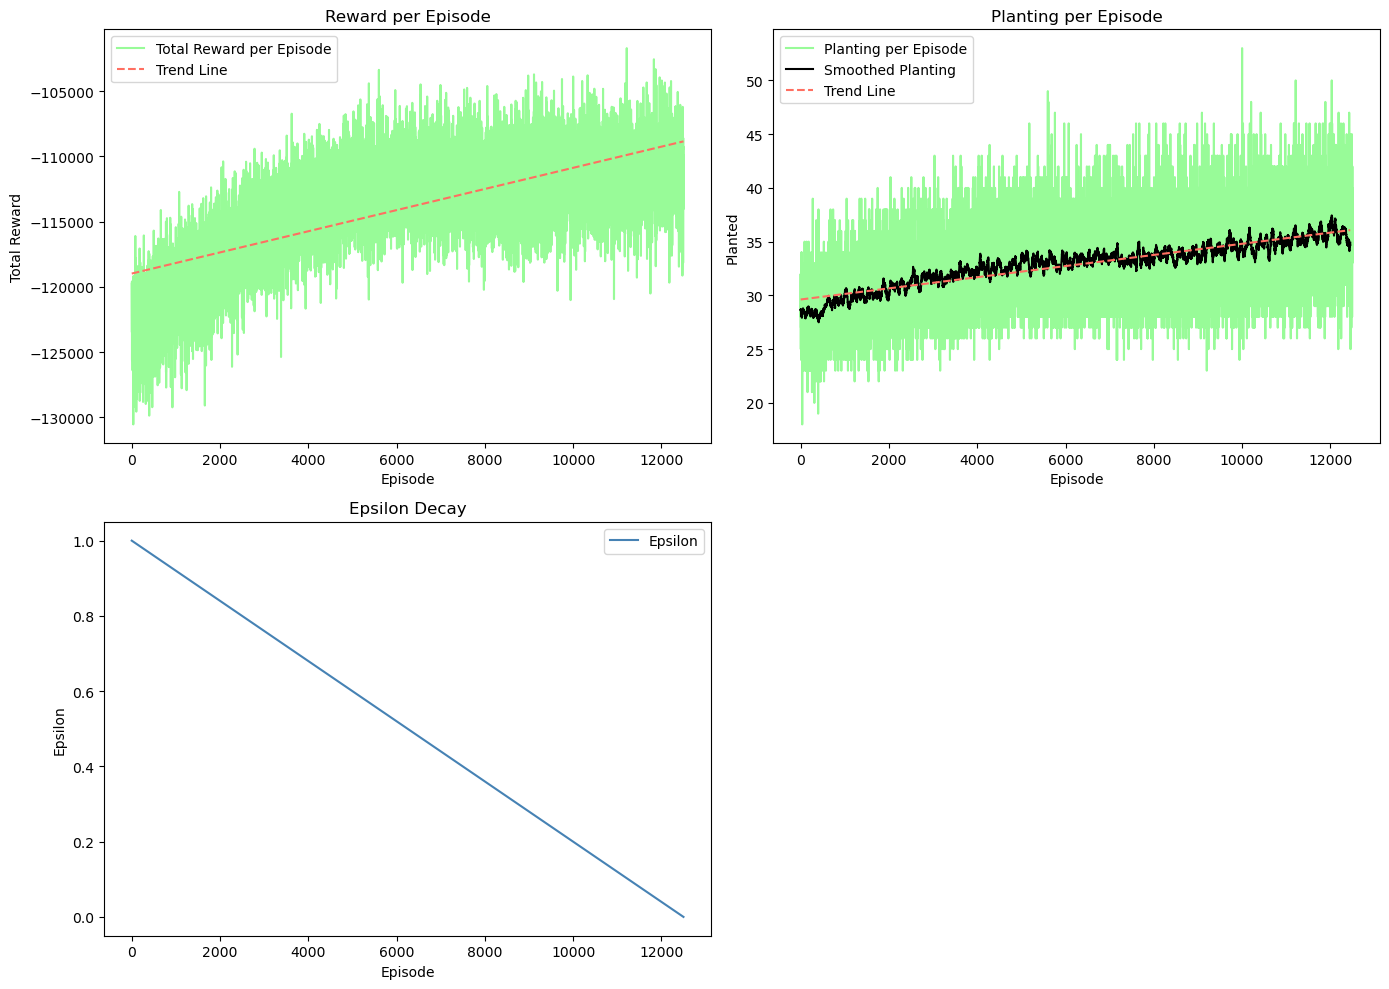

In [9]:
# Asegúrate de que rewards_per_episode y planting_per_episode sean arrays de NumPy
rewards_per_episode = np.array(rewards_per_episode)
planting_per_episode = np.array(planting_per_episode)

# Colores para las gráficas
color_reward = '#98FB98'  # Verde menta
color_trend_line = '#FF6F61'  # Coral
color_smoothed_planting = '#000'  # Negro
color_epsilon = '#4682B4'  # Azul acero

# Ajustar una línea recta (polinomio de grado 1) a los datos de recompensas
z_rewards = np.polyfit(range(len(rewards_per_episode)), rewards_per_episode, 1)
p_rewards = np.poly1d(z_rewards)

# Crear la gráfica de recompensas
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(rewards_per_episode, label='Total Reward per Episode', color=color_reward)
plt.plot(range(len(rewards_per_episode)), p_rewards(range(len(rewards_per_episode))), "r--", label='Trend Line', color=color_trend_line)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward per Episode')
plt.legend()

# Suavizar la serie de datos de plantación de semillas utilizando un promedio móvil
window_size = 50
smoothed_planting = np.convolve(planting_per_episode, np.ones(window_size)/window_size, mode='valid')

# Ajustar una línea recta (polinomio de grado 1) a los datos de plantación suavizados
z_planting = np.polyfit(range(len(smoothed_planting)), smoothed_planting, 1)
p_planting = np.poly1d(z_planting)

# Crear la gráfica de plantación de semillas
plt.subplot(2, 2, 2)
plt.plot(planting_per_episode, label='Planting per Episode', color=color_reward)
plt.plot(range(len(smoothed_planting)), smoothed_planting, label='Smoothed Planting', color=color_smoothed_planting)
plt.plot(range(len(smoothed_planting)), p_planting(range(len(smoothed_planting))), "r--", label='Trend Line', color=color_trend_line)
plt.xlabel('Episode')
plt.ylabel('Planted')
plt.title('Planting per Episode')
plt.legend()

# Crear la gráfica de epsilon
plt.subplot(2, 2, 3)
plt.plot(epsilon_values, label='Epsilon', color=color_epsilon)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay')
plt.legend()

plt.tight_layout()
plt.show()

## Red Neuronal

In [10]:
# Aquí va una red capaz de aprender a jugar al juego de los tractores

## Simulación Final

In [11]:
# Inicializar el modelo
model.reset()

# Steps
model.max_steps = 600

# Establecer epsilon a 0 para la simulación final
epsilon = 0
for tractor in model.agents:
    tractor.epsilon = epsilon

# Cargar las tablas Q completadas para cada tractor
for i, tractor in enumerate(model.agents):
    with open(f'q_table_{i}.pkl', 'rb') as f:
        tractor.q_table = pickle.load(f)

# Variables para almacenar recompensas y plantados
total_reward = 0
total_planted = 0
filenames = []

# Directorio temporal para almacenar cuadros
with TemporaryDirectory() as temp_dir:
    while model.steps < model.max_steps:
        reward, planted = model.step()  # Ejecutar un paso en el modelo
        total_reward += reward
        total_planted += planted

        # Comprobar si todos los tractores están destruidos
        if all(tractor.destroyed for tractor in model.agents):
            break

        # Guardar cuadro del estado actual del modelo
        filename = os.path.join(temp_dir, f'frame_{model.steps}.png')
        save_frame(model, filename, total_reward, total_planted, images)
        filenames.append(filename)

        # Imprimir progreso de la simulación
        print(f"Numero de pasos: {model.steps}")
        print(f"Recompensa total: {total_reward:.2f}, Plantados: {total_planted:.2f}")

    # Crear GIF de la simulación final
    gif_filename = 'simulacionFinal.gif'
    create_gif(filenames, gif_filename)

print("Simulación final guardada exitosamente en 'simulacionFinal.gif'")

Numero de pasos: 1
Recompensa total: -462.00, Plantados: 0.00
Numero de pasos: 2
Recompensa total: -875.00, Plantados: 1.00
Numero de pasos: 3
Recompensa total: -1224.00, Plantados: 3.00
Numero de pasos: 4
Recompensa total: -1683.00, Plantados: 3.00
Numero de pasos: 5
Recompensa total: -2088.00, Plantados: 4.00
Numero de pasos: 6
Recompensa total: -2650.00, Plantados: 4.00
Numero de pasos: 7
Recompensa total: -3066.00, Plantados: 5.00
Numero de pasos: 8
Recompensa total: -3578.00, Plantados: 6.00
Numero de pasos: 9
Recompensa total: -4341.00, Plantados: 6.00
Numero de pasos: 10
Recompensa total: -4909.00, Plantados: 6.00
Numero de pasos: 11
Recompensa total: -5323.00, Plantados: 7.00
Numero de pasos: 12
Recompensa total: -5894.00, Plantados: 7.00
Numero de pasos: 13
Recompensa total: -6451.00, Plantados: 7.00
Numero de pasos: 14
Recompensa total: -7029.00, Plantados: 7.00
Numero de pasos: 15
Recompensa total: -7610.00, Plantados: 7.00
Numero de pasos: 16
Recompensa total: -8101.00, Pla